In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from importlib import reload
from tqdm import tqdm_notebook as tqdm
from sklearn import linear_model as lm
from fuzzywuzzy import fuzz
import time

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# loading all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

278931 studies loaded!


In [4]:
# adding and loading dimensional data
ss.add_dimensions(['baseline_measurements',
                   'result_groups',
                   'eligibilities',
                   'outcomes',
                   'outcome_counts',
                   'outcome_measurements'])
ss.refresh_dim_data()

Successfuly added these 6 dimensions: ['baseline_measurements', 'result_groups', 'eligibilities', 'outcomes', 'outcome_counts', 'outcome_measurements']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 558 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension eligibilities
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_measurements
 -- Loading raw data
 -- Sorting index


In [5]:
# setting all the dimensional data to variables
bm = ss.dimensions['baseline_measurements'].data
rg = ss.dimensions['result_groups'].data
el = ss.dimensions['eligibilities'].data
out = ss.dimensions['outcomes'].data
oc = ss.dimensions['outcome_counts'].data
om = ss.dimensions['outcome_measurements'].data

In [6]:
# total number of studies
num_all = ss.studies.shape[0]
num_all

278931

In [7]:
# baseline measurement studies
bm_all = bm.index.get_level_values(0).unique().shape[0]
bm_all, bm_all / num_all

(42773, 0.1533461680487289)

### Finding age like fields:

In [13]:
bm.columns

Index(['id', 'ctgov_group_code', 'classification', 'category', 'title',
       'description', 'units', 'param_type', 'param_value', 'param_value_num',
       'dispersion_type', 'dispersion_value', 'dispersion_value_num',
       'dispersion_lower_limit', 'dispersion_upper_limit',
       'explanation_of_na'],
      dtype='object')

In [14]:
bm.groupby('title').size().sort_values(ascending=False)[:20]

title
Sex: Female, Male                                               236263
Age                                                             224845
Race (NIH/OMB)                                                  216063
Region of Enrollment                                            116346
Race/Ethnicity, Customized                                      102616
Ethnicity (NIH/OMB)                                              70455
Age, Customized                                                  34821
Gender                                                            7426
Weight                                                            4956
Sex/Gender, Customized                                            4947
Height                                                            3698
Body Mass Index (BMI)                                             3165
Education                                                         2415
Eastern Cooperative Oncology Group (ECOG) Performance Status      2169


In [15]:
used_titles = ['Age', 'Age, Customized']
used_types = ['Count of Participants', 'Number']

bm_used = bm[(bm['title'].isin(used_titles)) & (bm['param_type'].isin(used_types))]

# Steps 1-3 are investigative, step 4 starts implementation

# 1. Category column in BM

In [44]:
bmr = bm_used.reset_index()

In [45]:
all_cats = bmr.groupby('category')['nct_id'].count().sort_values(ascending=False)
all_cats[:30]

category
>=65 years                                  39350
Between 18 and 65 years                     39323
<=18 years                                  39315
                                            29953
≥ 65 years                                    188
< 65 years                                    162
18 - 64 years                                  58
50-59 years                                    56
GTE65                                          52
BTWN                                           52
LTE18                                          52
60-69 years                                    51
≥ 75 years                                     49
<65 years                                      49
Children (2-11 years)                          47
40-49 years                                    46
>=75 years                                     43
30-39 years                                    42
18-64 years                                    42
65 - 74 years                            

### we can use all of these categories ...

In [46]:
num_used = len(bm_used.index.get_level_values(0).unique())
num_used

18554

In [47]:
# this % of studies is covered by the current set
num_used / bm_all

0.4337783180978655

In [48]:
# eye balling through some of them
np.random.choice(bm_used.index.get_level_values(0).unique(), 5)

array(['NCT02971631', 'NCT00018031', 'NCT03124927', 'NCT02525055',
       'NCT01065844'], dtype=object)

# 2. Merging the category and classification into 1 used study set

In [49]:
double_counts = bm_used.groupby(['classification', 'category'])['id'].count().sort_values(ascending=False)
double_counts[double_counts > 500]

classification           category               
                         >=65 years                 39240
                         Between 18 and 65 years    39213
                         <=18 years                 39202
>=65 years                                           1462
Between 18 and 65 years                               666
<=18 years                                            626
<65 years                                             564
< 65 years                                            540
Name: id, dtype: int64

### Plan: We look at category first, then in the remaining where category is blank, look at the classification

## 3 a) Case 1: Category is non-blank

In [50]:
bm_used_case1 = bm_used[bm_used['category'] != '']

In [51]:
bm_used_case1.groupby('param_type').size()

param_type
Count of Participants    122761
dtype: int64

In [52]:
bm_used_case1 = bm_used_case1[bm_used_case1['param_type'] == 'Count of Participants']

# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case1.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case1_nct_ids = bm_used_case1.index.get_level_values(0).unique()

Pct of bm rows: 80.4%


In [53]:
bm_full_case1 = bm_used.loc[case1_nct_ids]
bm_full_case1 = bm_full_case1[bm_full_case1['param_type'] == 'Count of Participants']
print("Pct of bm rows: %.1f%%" % (bm_full_case1.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 80.5%


## Joining to result groups to get the group labels:

In [54]:
dfm_case1 = bm_full_case1.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [55]:
dfm_case1.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'All Study Participants',
       'Control Group', 'All Participants', 'Group 1', 'Usual Care',
       'Treatment', 'Intervention', 'Entire Study Population', 'Placebo Group',
       'Overall Study', 'Arm 1', 'Sugar Pill', 'Group 2', 'Total Title',
       'Standard of Care', 'Arm I', 'Single Arm', 'Arm 2', 'Group B',
       'Group A', 'All Patients', 'Cohort 1', 'Experimental',
       'Intervention Group', 'Vehicle', 'All Subjects', 'Active', 'Cohort 2',
       'Treatment Group', 'Normal Saline', 'Treatment Arm', 'Metformin',
       'Standard Care', 'Group 3', 'Control Arm', 'Saline',
       'Healthy Volunteers', 'Lacosamide', 'Placebo Arm', 'Varenicline',
       'Cohort 3', 'Levetiracetam', 'Aripiprazole', 'Arm A', 'Escitalopram',
       'Rotigotine', 'Pioglitazone'],
      dtype='object', name='title_rg')

In [56]:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [57]:
dfm_case1_nontot = dfm_case1[~dfm_case1['title_rg'].isin(total_strings)].copy()
len(dfm_case1_nontot['nct_id'].unique())

14926

In [58]:
dfm_case1_nontot['param_type'].unique()

array(['Count of Participants'], dtype=object)

In [59]:
df_case1_totcounts = dfm_case1_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c1j = df_case1_totcounts.join(ss.studies[['enrollment']])
df_c1j['tot_per_enroll'] = df_c1j['param_value_num'] / df_c1j['enrollment']
df_c1j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00000134,279.0,279.0,1.0
NCT00000135,209.0,209.0,1.0
NCT00000136,234.0,234.0,1.0
NCT00000142,64.0,64.0,1.0
NCT00000143,61.0,61.0,1.0


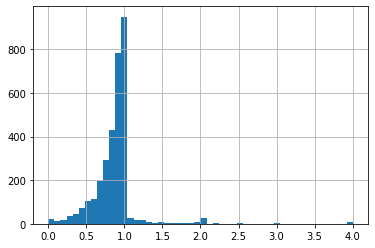

In [60]:
df_c1j[df_c1j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

### Idea: let's just keep those studies with totals that sum up to smaller or equal to total enrollment

In [61]:
non_double_counted = df_c1j[df_c1j['param_value_num'] <= df_c1j['enrollment']]
non_double_counted.shape[0] / df_c1j.shape[0]

0.9863995712180088

In [62]:
df_final_case1 = dfm_case1_nontot[dfm_case1_nontot['nct_id'].isin(non_double_counted.index)].copy()

In [63]:
# % of rows in bm_used
df_final_case1.shape[0] / bm_used.shape[0]

0.5897822072632503

In [64]:
# % of nct_ids in bm_used
len(df_final_case1['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.793521612590277

## 3 b) Case 2: Category is blank (look in the classification field)

In [65]:
bm_used_case2 = bm_used[bm_used['category'] == '']

In [66]:
bm_used_case2.groupby('param_type').size()

param_type
Count of Participants     5378
Number                   24575
dtype: int64

In [67]:
# checked that these 2 are the dominate characterstics
bm_used_case2 = bm_used_case2[bm_used_case2['param_type'].isin(['Count of Participants', 
                                                                'Number'])]


# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case2.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case2_nct_ids = bm_used_case2.index.get_level_values(0).unique()

Pct of bm rows: 19.6%


In [68]:
bm_full_case2 = bm_used.loc[case2_nct_ids]
bm_full_case2 = bm_full_case2[bm_full_case2['param_type'].isin(['Count of Participants', 'Number'])]
print("Pct of bm rows: %.1f%%" % (bm_full_case2.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 19.9%


## Joining to result groups to get the group labels:

In [69]:
dfm_case2 = bm_full_case2.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [70]:
dfm_case2.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Vehicle', 'All Participants',
       'Pregabalin', 'Placebo QD', 'Cohort 1', 'Cohort 2',
       'Entire Study Population', 'Control Group', 'Dasatinib', 'Doripenem',
       'Usual Care', 'Standard of Care', 'Bevacizumab',
       'Azilsartan Medoxomil 40 mg QD', 'Dexlansoprazole MR 60 mg QD',
       'Azilsartan Medoxomil 80 mg QD', 'Blinatumomab', 'Intervention',
       'Varenicline', 'Treatment', 'Group 1', 'Maraviroc QD', 'Dimebon',
       'Ziprasidone', 'Dexlansoprazole MR 90 mg QD', 'Celecoxib',
       'Subcutaneous Insulin', 'Adalimumab', 'Maraviroc BID',
       'Alogliptin 12.5 mg QD', 'Alogliptin 25 mg QD', 'Fesoterodine',
       'Inhaled Insulin', 'Dapagliflozin 10 mg', 'Total Title',
       'Fingolimod 0.5 mg', 'Ixabepilone', 'Sunitinib', 'Dapagliflozin 5 mg',
       'All Study Participants', 'Rivaroxaban (Xarelto, BAY59-7939)',
       'Placebo MDPI', 'Anidulafungin', 'Standard of Care (SOC)', 'Imatinib',
       'Docetaxel', 'Capecitabine'

In [71]:
# still the same total strings:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [72]:
dfm_case2_nontot = dfm_case2[~dfm_case2['title_rg'].isin(total_strings)].copy()
len(dfm_case2_nontot['nct_id'].unique())

3169

In [73]:
df_case2_totcounts = dfm_case2_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c2j = df_case2_totcounts.join(ss.studies[['enrollment']])
df_c2j['tot_per_enroll'] = df_c2j['param_value_num'] / df_c2j['enrollment']
df_c2j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00000392,122.0,215.0,0.567442
NCT00003377,29.0,29.0,1.000000
NCT00003644,542.0,571.0,0.949212
NCT00003869,186.0,186.0,1.000000
NCT00006227,31.0,31.0,1.000000


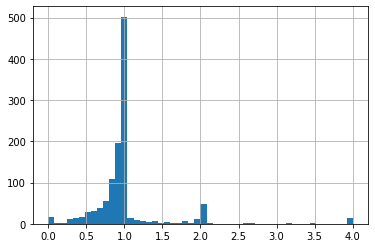

In [74]:
df_c2j[df_c2j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

In [75]:
non_double_counted_case2 = df_c2j[df_c2j['param_value_num'] <= df_c2j['enrollment']]
non_double_counted_case2.shape[0] / df_c2j.shape[0]

0.9517197854212686

In [76]:
df_final_case2 = dfm_case2_nontot[dfm_case2_nontot['nct_id'].isin(non_double_counted_case2.index)].copy()

In [77]:
# % of rows in bm_used
df_final_case2.shape[0] / bm_used.shape[0]

0.1386316906112079

In [78]:
# % of nct_ids in bm_used
len(df_final_case2['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.16255254931551147

### Do we have any nct_ids in both cases?

In [79]:
c1_nct = df_final_case1['nct_id'].unique()
c2_nct = df_final_case2['nct_id'].unique()

[x for x in c1_nct if x in c2_nct]

[]

In [80]:
df_final_case1['used_age'] = df_final_case1['category']
df_final_case2['used_age'] = df_final_case2['classification']

In [81]:
req_columns = [
    'nct_id', 
    'result_group_id',
    'title',
    'ctgov_group_code',
    'used_age',
    'param_value_num'
]

## 4 Joining together the cases

In [82]:
df_final_all = pd.concat([df_final_case1[req_columns], df_final_case2[req_columns]])

In [83]:
df_final_all.shape[0] / bm_used.shape[0]

0.7284138978744581

In [84]:
# % of all nctids that report baseline measures
num_studies_report_race = len(df_final_all['nct_id'].unique())
num_studies_report_race / len(bm.index.get_level_values(0).unique()), num_studies_report_race

(0.41472424192831925, 17739)

In [85]:
dftotals = df_final_all.groupby('nct_id')[['param_value_num']].sum()

In [86]:
df_percentile_totals = dftotals.describe(np.arange(0,1,0.01))
df_percentile_totals.index.name='percentile'
df_percentile_totals.reset_index(inplace=True)
df_percentile_totals = df_percentile_totals[df_percentile_totals['percentile'].apply(lambda x: 
                                                                                     True if '%' in x 
                                                                                     else False)]
df_percentile_totals[15:25]

,percentile,param_value_num
19,15%,11.0
20,16%,12.0
21,17%,12.0
22,18%,13.0
23,19%,14.0
24,20%,15.0
25,21%,16.0
26,22%,16.0
27,23%,17.0
28,24%,18.0


### We picked to keep 80% of the data and exclude any studies such the total <= 15

In [87]:
df_totals_used = dftotals[dftotals['param_value_num'] > 15]
df_totals_used.shape

(14020, 1)

In [88]:
df_final_g15 = df_final_all[df_final_all['nct_id'].isin(df_totals_used.index.unique())]
df_final_g15.head()

,nct_id,result_group_id,title,ctgov_group_code,used_age,param_value_num
3,NCT00000134,17107284,Age,B3,>=65 years,0.0
4,NCT00000134,17107284,Age,B3,Between 18 and 65 years,96.0
5,NCT00000134,17107284,Age,B3,<=18 years,0.0
6,NCT00000134,17107285,Age,B2,>=65 years,0.0
7,NCT00000134,17107285,Age,B2,Between 18 and 65 years,94.0


### Only keep those with 2 Arms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe062509fd0>]],
      dtype=object)

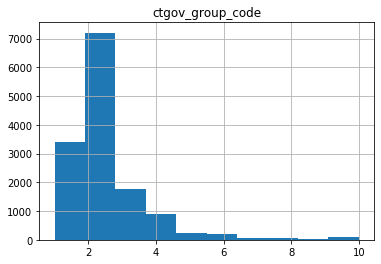

In [89]:
df_final_g15.groupby('nct_id')[['ctgov_group_code']].nunique().clip(0, 10).hist(bins=10)

In [90]:
# only keep studies with exactly 2 arms
s_ngrps = df_final_g15.groupby('nct_id')['ctgov_group_code'].nunique()
nct_id_2arm = s_ngrps[s_ngrps == 2].index
len(nct_id_2arm)

7204

In [91]:
# % of studies with bm
# % of all studies in database
len(nct_id_2arm) / bm_all, len(nct_id_2arm) / num_all 

(0.16842400579805017, 0.025827175896547892)

In [92]:
df_final_two_arm = df_final_g15[df_final_g15['nct_id'].isin(nct_id_2arm)]
df_final_two_arm.shape

(43001, 6)

In [93]:
df_final_two_arm.head()

,nct_id,result_group_id,title,ctgov_group_code,used_age,param_value_num
15,NCT00000135,17107275,Age,B2,>=65 years,0.0
16,NCT00000135,17107275,Age,B2,Between 18 and 65 years,105.0
17,NCT00000135,17107275,Age,B2,<=18 years,0.0
18,NCT00000135,17107276,Age,B1,>=65 years,0.0
19,NCT00000135,17107276,Age,B1,Between 18 and 65 years,104.0


# 5. Outcome measurements

In [94]:
omj = om.reset_index().add_prefix('om_')
outj = out.reset_index().add_prefix('out_')

In [95]:
dfj = omj.merge(outj, 
                how='inner',
                left_on=['om_nct_id', 'om_outcome_id'],
                right_on=['out_nct_id', 'out_id'],)

In [96]:
# studies from the baseline measurement race requirements above
studies_w_race_info = df_final_two_arm['nct_id'].unique()
len(studies_w_race_info)

7204

In [97]:
# studies with 1 primary outcome
outj_primary = outj[outj['out_outcome_type'] == 'Primary']
num_outcomes_per_study = outj_primary.groupby('out_nct_id')['out_id'].size()
studies_w_1_outcome = num_outcomes_per_study[num_outcomes_per_study == 1].index
len(studies_w_1_outcome)

28745

In [98]:
# intersection of the two requirements
dfj_used = dfj[(dfj['om_nct_id'].isin(studies_w_race_info)) &
               (dfj['om_nct_id'].isin(studies_w_1_outcome))]
len(dfj_used['om_nct_id'].unique())

4949

In [99]:
dfom_prim = dfj_used[(dfj_used['out_param_type'] == 'Mean') & (dfj_used['out_outcome_type'] == 'Primary')]
len(dfom_prim['om_nct_id'].unique())

2063

In [100]:
# needs to have exactly 2 unique group codes
num_group_codes = dfom_prim.groupby('om_nct_id')['om_ctgov_group_code'].size()
with_2_g_codes = num_group_codes[num_group_codes == 2].index

num_uniq_group_codes = dfom_prim.groupby('om_nct_id')['om_ctgov_group_code'].nunique()
with_2_uniq_g_codes = num_uniq_group_codes[num_uniq_group_codes == 2].index

In [101]:
dfom_all_types = dfom_prim[(dfom_prim['om_nct_id'].isin(with_2_g_codes)) &
                       (dfom_prim['om_nct_id'].isin(with_2_uniq_g_codes))]
len(dfom_all_types['om_nct_id'].unique())

1491

In [102]:
dfom_all_types.groupby('om_dispersion_type').size()

om_dispersion_type
80% Confidence Interval         2
90% Confidence Interval         2
95% Confidence Interval       292
97.5% Confidence Interval       2
Full Range                     94
Inter-Quartile Range           20
Standard Deviation           2234
Standard Error                336
dtype: int64

In [103]:
used_dispersion_types = ['Standard Deviation', 'Standard Error']
dfom_final = dfom_all_types[dfom_all_types['om_dispersion_type'].isin(used_dispersion_types)]
len(dfom_final['om_nct_id'].unique())

1285

#### We arrive at a final om dataset of 1264 studies

## On the outcome counts, getting the primary counts

In [104]:
# requires the outcome table and the outcome_counts table
ocj = oc.reset_index().add_prefix('oc_')
out_ocj = out[['id', 'outcome_type']].reset_index().add_prefix('oco_')

ocoj = ocj.merge(out_ocj,
                 how='inner', 
                 left_on=['oc_nct_id', 'oc_outcome_id'],
                 right_on=['oco_nct_id', 'oco_id'])
ocoj_in_set = ocoj[ocoj['oc_nct_id'].isin(dfom_final['om_nct_id'].unique())]

# only keep counts on primary out comes
ocoj_primary = ocoj_in_set[ocoj_in_set['oco_outcome_type'] == 'Primary']

len(ocoj_primary['oc_nct_id'].unique())

1285

In [105]:
# extracting the out_come counts:
res_dict = {}

for nct_id in tqdm(ocoj_primary['oc_nct_id'].unique()):
    #print(nct_id)
    sub_df = ocoj_primary[ocoj_primary['oc_nct_id'] == nct_id]
    for gcode in sub_df['oc_ctgov_group_code'].unique():
        sub_df_gc = sub_df[sub_df['oc_ctgov_group_code'] == gcode]
        type_units = sub_df_gc['oc_units'].unique()

        if len(type_units) == 1:
            num_participants = sub_df_gc['oc_count'].values[0]
            num_measures = sub_df_gc['oc_count'].values[0]  # same as participants
        elif len(type_units) == 2:
            num_participants = sub_df_gc[sub_df_gc['oc_units'] == 'Participants']['oc_count'].values[0]
            num_measures = sub_df_gc[sub_df_gc['oc_units'] != 'Participants']['oc_count'].values[0]

        res_dict[(nct_id, gcode)] = {
            'num_participants': num_participants,
            'num_measures': num_measures,
        }
        
df_counts = pd.DataFrame(res_dict).T
df_counts.index.names = ['nct_id', 'ctgov_group_code']
df_counts = df_counts.reset_index().add_prefix('ct_')
df_counts

,ct_nct_id,ct_ctgov_group_code,ct_num_participants,ct_num_measures
0,NCT00000371,O2,27,27
1,NCT00000371,O1,28,28
2,NCT00000392,O2,77,77
3,NCT00000392,O1,66,66
4,NCT00001596,O2,3,3
...,...,...,...,...
2568,NCT04195880,O1,3205,3205
2569,NCT04266925,O2,49,49
2570,NCT04266925,O1,49,49
2571,NCT04502979,O2,26,26


## Joining the counts to dfom_final

In [106]:
dfom_final.shape

(2570, 32)

In [107]:
df_om_final_w_counts = dfom_final.merge(df_counts,
                                        how='inner',
                                        left_on=['om_nct_id', 'om_ctgov_group_code'],
                                        right_on=['ct_nct_id', 'ct_ctgov_group_code'])
df_om_final_w_counts.shape

(2570, 36)

In [108]:
df_om_final_w_counts.columns

Index(['om_nct_id', 'om_result_group_id', 'om_outcome_id', 'om_id',
       'om_ctgov_group_code', 'om_classification', 'om_category', 'om_title',
       'om_description', 'om_units', 'om_param_type', 'om_param_value',
       'om_param_value_num', 'om_dispersion_type', 'om_dispersion_value',
       'om_dispersion_value_num', 'om_dispersion_lower_limit',
       'om_dispersion_upper_limit', 'om_explanation_of_na', 'out_nct_id',
       'out_id', 'out_outcome_type', 'out_title', 'out_description',
       'out_time_frame', 'out_population', 'out_anticipated_posting_date',
       'out_anticipated_posting_month_year', 'out_units', 'out_units_analyzed',
       'out_dispersion_type', 'out_param_type', 'ct_nct_id',
       'ct_ctgov_group_code', 'ct_num_participants', 'ct_num_measures'],
      dtype='object')

## Taking the intersection of the 2 datasets

In [109]:
dfbm_final_i = df_final_two_arm[df_final_two_arm['nct_id'].isin(df_om_final_w_counts['om_nct_id'].unique())]
dfbm_final_i = dfbm_final_i.add_prefix('bm_')
dfom_final_i = df_om_final_w_counts[df_om_final_w_counts['om_nct_id'].isin(df_final_two_arm['nct_id'].unique())]

In [110]:
dfbm_final_i.shape, dfom_final_i.shape

((7646, 6), (2570, 36))

In [111]:
# checkpoint outputting data pickels
dfbm_final_i.to_pickle('bm_age.p')
dfom_final_i.to_pickle('om_age.p')

In [112]:
sample_nct_id = 'NCT00000392'

In [113]:
# joining the result groups to dfom
rg_omj = rg.reset_index().add_prefix("rgom_")
dfom_final_ij = dfom_final_i.merge(rg_omj,
                                   how='inner',
                                   left_on=['om_nct_id', 'om_result_group_id'],
                                   right_on=['rgom_nct_id', 'rgom_id'])
dfom_final_ij.shape

(2570, 42)

In [114]:
dfom_final_ij[dfom_final_ij['om_nct_id'] == sample_nct_id].T

,2,3
om_nct_id,NCT00000392,NCT00000392
om_result_group_id,17106864,17106865
om_outcome_id,5194677,5194677
om_id,39880275,39880276
om_ctgov_group_code,O2,O1
om_classification,,
om_category,,
om_title,Change in Global Neurocognitive Performance z ...,Change in Global Neurocognitive Performance z ...
om_description,Higher values for change in z-score represent ...,Higher values for change in z-score represent ...
om_units,z score,z score


In [115]:
# joining the result groups to dfbm
rg_bmj = rg.reset_index().add_prefix("rgbm_")
dfbm_final_ij = dfbm_final_i.merge(rg_bmj,
                                   how='inner',
                                   left_on=['bm_nct_id', 'bm_result_group_id'],
                                   right_on=['rgbm_nct_id', 'rgbm_id'])
dfbm_final_ij.shape

(7646, 12)

In [116]:
dfbm_final_ij[dfbm_final_ij['bm_nct_id'] == sample_nct_id].T

,7102,7103
bm_nct_id,NCT00000392,NCT00000392
bm_result_group_id,17106858,17106859
bm_title,"Age, Customized","Age, Customized"
bm_ctgov_group_code,B2,B1
bm_used_age,18-39 years,18-39 years
bm_param_value_num,62,60
rgbm_nct_id,NCT00000392,NCT00000392
rgbm_id,17106858,17106859
rgbm_ctgov_group_code,B2,B1
rgbm_result_type,Baseline,Baseline


In [117]:
# saving pickles
dfbm_final_ij.to_pickle('final_bm_age.p')
dfom_final_ij.to_pickle('final_om_age.p')

# 7. Compute imbalance and effect from the data

In [121]:
# loop to compute all effects and imbalances
all_res = {}  # storing final results

for nct_id in tqdm(dfom_final_ij['om_nct_id'].unique()):
    all_res[nct_id] = {}  # inner dict for storage
    sub_om = dfom_final_ij[dfom_final_ij['om_nct_id'] == nct_id]
    sub_bm = dfbm_final_ij[dfbm_final_ij['bm_nct_id'] == nct_id]
    
    # difference in mean
    abs_mean_diff = np.abs(sub_om['om_param_value_num'].values[0] - sub_om['om_param_value_num'].values[1])
    
    # standard error estimate
    sd_type1 = sub_om['out_dispersion_type'].values[0]
    sd_type2 = sub_om['out_dispersion_type'].values[1]
    num_m1 = sub_om['ct_num_measures'].values[0]
    num_m2 = sub_om['ct_num_measures'].values[1]
    sd_1 = sub_om['om_dispersion_value_num'].values[0]
    sd_2 = sub_om['om_dispersion_value_num'].values[1]
    
    # if the type is Standard Error, then we need to scale it by the sqrt of the count, since it has been adjusted
    if sd_type1 == 'Standard Error':
        sd_1 = sd_1 * np.sqrt(num_m1)
    if sd_type2 == 'Standard Error':
        sd_2 = sd_2 * np.sqrt(num_m2)
    
    sd_est = np.sqrt((num_m1 * sd_1 ** 2 + num_m2 * sd_2 **2) / (num_m1 + num_m2))
    
    effect = abs_mean_diff / sd_est
    all_res[nct_id]['effect'] = effect
    
    # details
    all_res[nct_id]['g1_mean'] = num_m1
    all_res[nct_id]['g2_mean'] = num_m2
    all_res[nct_id]['g1_sd_sample'] = sd_1
    all_res[nct_id]['g2_sd_sample'] = sd_2
    
    # imbalance
    bm_g_sums = sub_bm.groupby(['bm_ctgov_group_code', 'bm_used_age'])[['bm_param_value_num']].sum().reset_index()
    dfp = bm_g_sums.pivot(columns='bm_used_age', index='bm_ctgov_group_code', values='bm_param_value_num')
    dfp.index = ['g1', 'g2']
    dfpct = dfp.T / dfp.sum(axis=1)
    imbal = 1 - dfpct.min(axis=1).sum()
    all_res[nct_id]['imbal'] = imbal
    
    # number of groups
    all_res[nct_id]['ngrps'] = sub_bm.shape[0] / 2
    
    # other details
    all_res[nct_id]['g1t'] = dfp.T['g1'].sum()
    all_res[nct_id]['g2t'] = dfp.T['g2'].sum()
    all_res[nct_id]['g1counts'] = dfp.T['g1'].values
    all_res[nct_id]['g2counts'] = dfp.T['g2'].values
    all_res[nct_id]['grouplabels'] = list(dfp.T.index)

df_res = pd.DataFrame(all_res).T.dropna()
df_res.head()



/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbal,ngrps,g1t,g2t,g1counts,g2counts,grouplabels
NCT00000371,0.0317977,27,28,1.61081,1.53454,0,3,27,28,"[0.0, 0.0, 27.0]","[0.0, 0.0, 28.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00000392,0.237493,77,66,0.263249,0.406202,0,1,60,62,[60.0],[62.0],[18-39 years]
NCT00001596,0.105295,3,11,25.59,24.32,0.0434783,3,23,12,"[0.0, 1.0, 22.0]","[0.0, 0.0, 12.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00001723,0.3,100,100,0.2,0.2,0,3,100,100,"[100.0, 0.0, 0.0]","[100.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00004500,0.224826,31,38,8.52,9.96,0,3,38,31,"[38.0, 0.0, 0.0]","[31.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]"


In [122]:
# lost 4 records due to Nan in the numerical values
df_res.shape

(1281, 12)

### Exclude those with just 1 group

In [124]:
df_res_mult_grps = df_res[df_res['ngrps'] > 1].copy()
df_res.shape[0], df_res_mult_grps.shape[0]

(1281, 1261)

In [126]:
# casting ...
df_res_mult_grps['effect'] = df_res_mult_grps['effect'].astype(float)
df_res_mult_grps['g1_mean'] = df_res_mult_grps['g1_mean'].astype(float)
df_res_mult_grps['g2_mean'] = df_res_mult_grps['g2_mean'].astype(float)
df_res_mult_grps['g1_sd_sample'] = df_res_mult_grps['g1_sd_sample'].astype(float)
df_res_mult_grps['g2_sd_sample'] = df_res_mult_grps['g2_sd_sample'].astype(float)
df_res_mult_grps['imbal'] = df_res_mult_grps['imbal'].astype(float)
df_res_mult_grps['ngrps'] = df_res_mult_grps['ngrps'].astype(int)
df_res_mult_grps['g1t'] = df_res_mult_grps['g1t'].astype(int)
df_res_mult_grps['g2t'] = df_res_mult_grps['g2t'].astype(int)


In [127]:
df_res_mult_grps.to_pickle('res_age.p')